In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.environments.icu_sepsis_wrapper import create_sepsis_env, ICUSepsisWrapper

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

## 1. Environment Overview

The ICU-Sepsis environment simulates sepsis treatment in an ICU setting:
- **States**: 716 discrete states representing patient condition
- **Actions**: 25 discrete actions (5 vasopressor levels × 5 IV fluid levels)
- **Rewards**: Sparse (+1 survival, -1 death, 0 otherwise)

In [2]:
# Create the environment
env = create_sepsis_env(use_action_masking=True)

print("Environment Details:")
print(f"  Observation space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print(f"  Number of states: {env.n_states}")
print(f"  Number of actions: {env.n_actions}")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Environment Details:
  Observation space: Discrete(716)
  Action space: Discrete(25)
  Number of states: 716
  Number of actions: 25


## 2. Action Space Analysis

Actions are combinations of:
- Vasopressor dose (0-4)
- IV fluid volume (0-4)

In [3]:
# Action decomposition
print("Action Space (Vasopressor × IV Fluid):")
print("\nAction ID | Vasopressor | IV Fluid")
print("-" * 35)

for action in range(25):
    vaso = action // 5
    iv = action % 5
    print(f"    {action:2d}    |      {vaso}      |    {iv}")

Action Space (Vasopressor × IV Fluid):

Action ID | Vasopressor | IV Fluid
-----------------------------------
     0    |      0      |    0
     1    |      0      |    1
     2    |      0      |    2
     3    |      0      |    3
     4    |      0      |    4
     5    |      1      |    0
     6    |      1      |    1
     7    |      1      |    2
     8    |      1      |    3
     9    |      1      |    4
    10    |      2      |    0
    11    |      2      |    1
    12    |      2      |    2
    13    |      2      |    3
    14    |      2      |    4
    15    |      3      |    0
    16    |      3      |    1
    17    |      3      |    2
    18    |      3      |    3
    19    |      3      |    4
    20    |      4      |    0
    21    |      4      |    1
    22    |      4      |    2
    23    |      4      |    3
    24    |      4      |    4


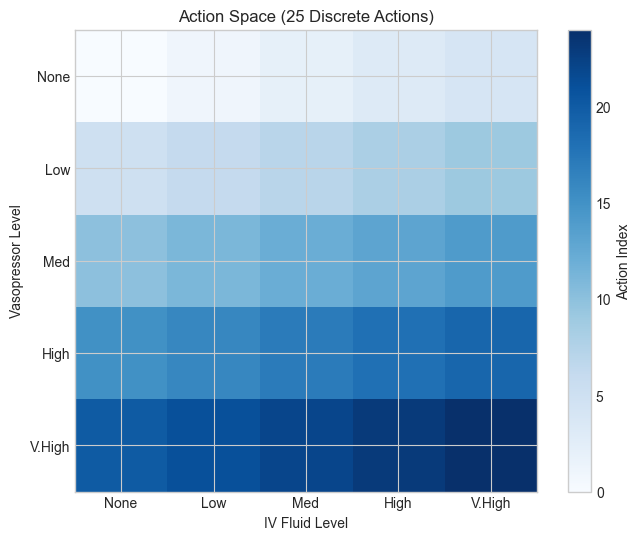

In [4]:
# Visualise action grid
fig, ax = plt.subplots(figsize=(8, 6))

action_grid = np.arange(25).reshape(5, 5)
im = ax.imshow(action_grid, cmap='Blues')

ax.set_xlabel('IV Fluid Level')
ax.set_ylabel('Vasopressor Level')
ax.set_title('Action Space (25 Discrete Actions)')
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(['None', 'Low', 'Med', 'High', 'V.High'])
ax.set_yticklabels(['None', 'Low', 'Med', 'High', 'V.High'])

plt.colorbar(im, label='Action Index')
plt.show()

## 3. Running Episodes

Let's run some episodes with a random policy to understand the environment dynamics.

In [5]:
def run_episode(env, policy='random', seed=None):
    """Run a single episode and collect trajectory."""
    if seed is not None:
        state, info = env.reset(seed=seed)
    else:
        state, info = env.reset()
    
    trajectory = {
        'states': [state],
        'actions': [],
        'rewards': [],
    }
    
    done = False
    total_reward = 0
    
    while not done:
        # Select action
        if policy == 'random':
            action = env.action_space.sample()
        elif policy == 'no_treatment':
            action = 0  # No vasopressor, no IV
        elif policy == 'max_treatment':
            action = 24  # Max vasopressor, max IV
        else:
            action = env.action_space.sample()
        
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        trajectory['actions'].append(action)
        trajectory['rewards'].append(reward)
        trajectory['states'].append(next_state)
        
        total_reward += reward
        state = next_state
    
    return trajectory, total_reward

In [6]:
# Run multiple episodes with random policy
n_episodes = 100
returns = []
lengths = []
outcomes = []  # 1 for survival, 0 for death

for i in range(n_episodes):
    trajectory, total_reward = run_episode(env, policy='random', seed=i)
    returns.append(total_reward)
    lengths.append(len(trajectory['actions']))
    outcomes.append(1 if total_reward > 0 else 0)

print(f"Random Policy Statistics ({n_episodes} episodes):")
print(f"  Survival rate: {np.mean(outcomes):.1%}")
print(f"  Mean return: {np.mean(returns):.3f} ± {np.std(returns):.3f}")
print(f"  Mean episode length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")

Random Policy Statistics (100 episodes):
  Survival rate: 81.0%
  Mean return: 0.810 ± 0.392
  Mean episode length: 8.0 ± 8.1


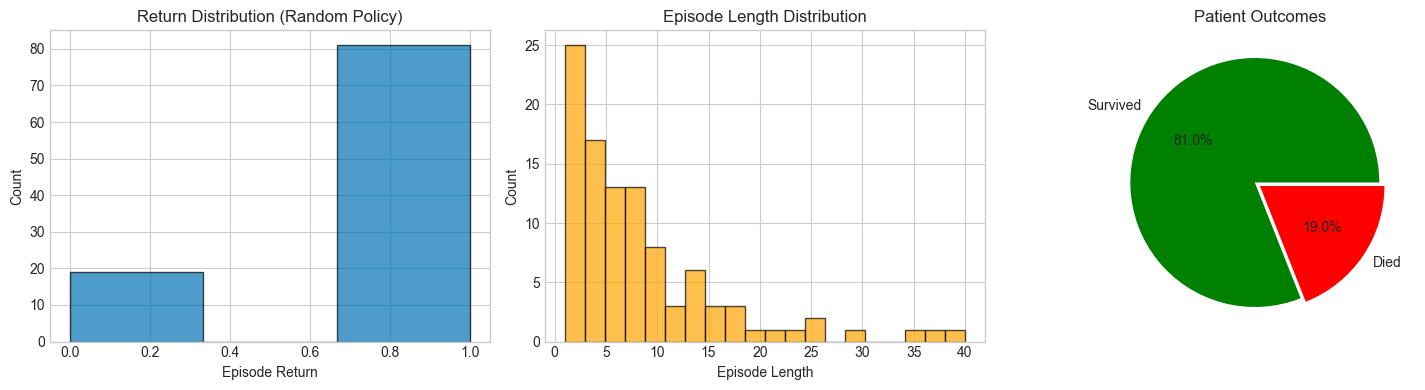

In [7]:
# Visualise episode statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Return distribution
axes[0].hist(returns, bins=3, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Episode Return')
axes[0].set_ylabel('Count')
axes[0].set_title('Return Distribution (Random Policy)')

# Episode length distribution
axes[1].hist(lengths, bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Episode Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Episode Length Distribution')

# Survival rate pie chart
survival_counts = [sum(outcomes), len(outcomes) - sum(outcomes)]
axes[2].pie(survival_counts, labels=['Survived', 'Died'], autopct='%1.1f%%',
            colors=['green', 'red'], explode=[0.05, 0])
axes[2].set_title('Patient Outcomes')

plt.tight_layout()
plt.show()

## 4. Comparing Different Policies

Let's compare different simple policies to understand the environment better.

In [8]:
def evaluate_policy(env, policy, n_episodes=100):
    """Evaluate a policy over multiple episodes."""
    returns = []
    for i in range(n_episodes):
        _, total_reward = run_episode(env, policy=policy, seed=i)
        returns.append(total_reward)
    
    survival_rate = np.mean([r > 0 for r in returns])
    return {
        'mean_return': np.mean(returns),
        'std_return': np.std(returns),
        'survival_rate': survival_rate,
    }

policies = ['random', 'no_treatment', 'max_treatment']
results = {}

for policy in policies:
    results[policy] = evaluate_policy(env, policy, n_episodes=100)
    print(f"{policy}: Survival={results[policy]['survival_rate']:.1%}, "
          f"Return={results[policy]['mean_return']:.3f}")

random: Survival=75.0%, Return=0.750
no_treatment: Survival=80.0%, Return=0.800
max_treatment: Survival=81.0%, Return=0.810


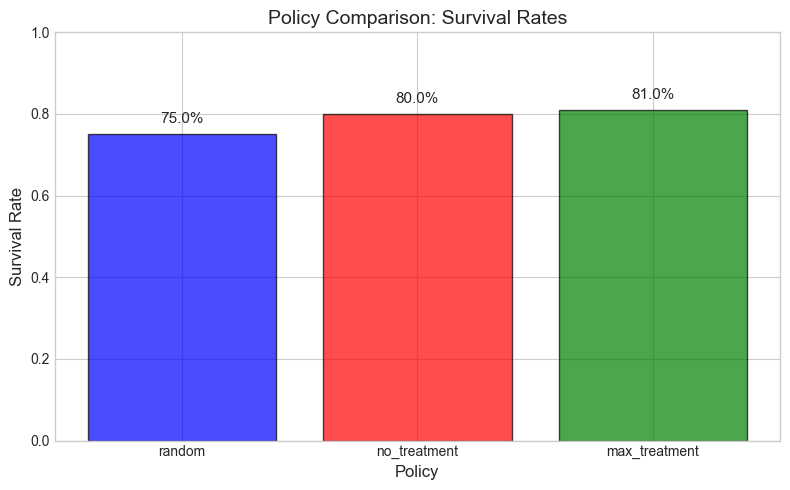

In [9]:
# Visualise policy comparison
fig, ax = plt.subplots(figsize=(8, 5))

policy_names = list(results.keys())
survival_rates = [results[p]['survival_rate'] for p in policy_names]

bars = ax.bar(policy_names, survival_rates, color=['blue', 'red', 'green'], alpha=0.7, edgecolor='black')

ax.set_xlabel('Policy', fontsize=12)
ax.set_ylabel('Survival Rate', fontsize=12)
ax.set_title('Policy Comparison: Survival Rates', fontsize=14)
ax.set_ylim([0, 1])

# Add value labels
for bar, rate in zip(bars, survival_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{rate:.1%}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 5. Key Takeaways

From this exploration:

1. The ICU-Sepsis environment has 716 discrete states, 25 actions, and sparse terminal rewards (+1 survival, -1 death).
2. Simple policies over 100 episodes: random ≈75% survival, no_treatment ≈80%, max_treatment ≈81%.
3. Gains from naive policies are small; learning from offline data (e.g., CQL) is needed to do better.